In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load the data
df = pd.read_csv(r'c:\Users\User\NTU_DSAI\Module-1\00_Coaching_Mod1_Project_1-2\data\SGJobData.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())

print(df.head(25))
print(df.describe())

Dataset shape: (1048585, 22)

Column names:
['categories', 'employmentTypes', 'metadata_expiryDate', 'metadata_isPostedOnBehalf', 'metadata_jobPostId', 'metadata_newPostingDate', 'metadata_originalPostingDate', 'metadata_repostCount', 'metadata_totalNumberJobApplication', 'metadata_totalNumberOfView', 'minimumYearsExperience', 'numberOfVacancies', 'occupationId', 'positionLevels', 'postedCompany_name', 'salary_maximum', 'salary_minimum', 'salary_type', 'status_id', 'status_jobStatus', 'title', 'average_salary']


In [4]:
# Data quality check
print("Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])
print(f"\nTotal records: {len(df)}")

Missing Values:
categories                         3988
employmentTypes                    3988
metadata_expiryDate                3988
metadata_jobPostId                 3988
metadata_newPostingDate            3988
metadata_originalPostingDate       3988
occupationId                    1048585
positionLevels                     3988
postedCompany_name                 3988
salary_type                        3988
status_jobStatus                   3988
title                              3988
dtype: int64

Total records: 1048585


In [5]:
# Remove rows with missing values in critical columns
print("Data Cleaning - Remove rows with missing critical data:")
print("="*80)
print(f"Original dataset: {len(df)} rows")

# Define critical columns that must have values for analysis
critical_columns = ['categories', 'employmentTypes', 'title', 'salary_minimum', 
                   'salary_maximum', 'average_salary', 'postedCompany_name',
                   'positionLevels', 'metadata_totalNumberOfView']

# Remove rows with NaN/missing values in critical columns
initial_count = len(df)
df = df.dropna(subset=critical_columns)
rows_removed = initial_count - len(df)

print(f"After removing rows with missing critical data: {len(df)} rows")
print(f"Rows removed: {rows_removed}")

# Check if those 3988 rows are gone
print(f"\nMissing values summary AFTER cleaning:")
missing_after = df.isnull().sum()
print(missing_after[missing_after > 0])

print("="*80)

Data Cleaning - Remove rows with missing critical data:
Original dataset: 1048585 rows
After removing rows with missing critical data: 1044597 rows
Rows removed: 3988

Missing values summary AFTER cleaning:
occupationId    1044597
dtype: int64


In [8]:
# Decided to do RUTHLESS filtering to remove outliers and junk data: minimumYearsExperience > 10 years, salary > $30,000/month, salary < $1,000/month, and constrain to 2023-May to 2024-May.

# RUTHLESS FILTERING - Create filtered dataframe for analysis
print("RUTHLESS DATA FILTERING - Creating df_filtered for analysis")
print("="*80)
print(f"Original records: {len(df)}")

# Create filtered dataframe for analysis
df_filtered = df.copy()

# 0. Constrain to date range: 2023-May to 2024-May
before = len(df_filtered)
df_filtered['posting_date'] = pd.to_datetime(df_filtered['metadata_newPostingDate'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['posting_date'])
df_filtered = df_filtered[(df_filtered['posting_date'] >= '2023-05-01') & (df_filtered['posting_date'] <= '2024-05-31')]
print(f"Constrained to 2023-May to 2024-May: {before - len(df_filtered)} rows dropped")

# 1. Remove jobs requiring more than 10 years experience
before = len(df_filtered)
df_filtered = df_filtered[df_filtered['minimumYearsExperience'] <= 10]
print(f"Removed experience > 10 years: {before - len(df_filtered)} rows dropped")

# 2. Remove jobs with monthly salary > $30,000
before = len(df_filtered)
df_filtered = df_filtered[df_filtered['salary_maximum'] <= 30000]
print(f"Removed salary > $30,000/month: {before - len(df_filtered)} rows dropped")

# 3. Remove jobs with monthly salary < $1,000
before = len(df_filtered)
df_filtered = df_filtered[df_filtered['salary_minimum'] >= 1000]
print(f"Removed salary < $1,000/month: {before - len(df_filtered)} rows dropped")

# Recalculate average_salary after filtering
df_filtered['average_salary'] = (df_filtered['salary_minimum'] + df_filtered['salary_maximum']) / 2

print(f"\nFiltered dataframe (df_filtered) records: {len(df_filtered)}")
print(f"Original dataframe (df) records: {len(df)}")
print(f"\nFiltered data ranges:")
print(f"  Date range: {df_filtered['posting_date'].min()} to {df_filtered['posting_date'].max()}")
print(f"  Experience: {df_filtered['minimumYearsExperience'].min()} - {df_filtered['minimumYearsExperience'].max()} years")
print(f"  Min Salary: ${df_filtered['salary_minimum'].min():,.0f} - ${df_filtered['salary_minimum'].max():,.0f}")
print(f"  Max Salary: ${df_filtered['salary_maximum'].min():,.0f} - ${df_filtered['salary_maximum'].max():,.0f}")
print(f"  Avg Salary: ${df_filtered['average_salary'].min():,.0f} - ${df_filtered['average_salary'].max():,.0f}")
print("="*80)

# Output df_filtered to CSV file
df_filtered.to_csv('./data/df_filtered.csv', index=False)
print(f"\n✅ Filtered dataframe saved to 'df_filtered.csv' ({len(df_filtered)} records)")

RUTHLESS DATA FILTERING - Creating df_filtered for analysis
Original records: 1044597
Constrained to 2023-May to 2024-May: 37598 rows dropped
Removed experience > 10 years: 8893 rows dropped
Removed salary > $30,000/month: 1057 rows dropped
Removed salary < $1,000/month: 17832 rows dropped

Filtered dataframe (df_filtered) records: 979217
Original dataframe (df) records: 1044597

Filtered data ranges:
  Date range: 2023-05-01 00:00:00 to 2024-05-29 00:00:00
  Experience: 0 - 10 years
  Min Salary: $1,000 - $30,000
  Max Salary: $1,000 - $30,000
  Avg Salary: $1,000 - $30,000

✅ Filtered dataframe saved to 'df_filtered.csv' (979217 records)


## (1) Expand Categories: Create Separate Columns for Each Category in a Job

Many jobs have multiple categories (up to ~5 in this dataset). Instead of keeping them in a list or exploding the DataFrame (which would duplicate rows), we create a fixed number of new columns: `category_1`, `category_2`, ..., `category_5`.  
- The categories are sorted alphabetically per job to ensure consistency.  
- Empty strings for jobs with fewer categories.

```python



In [9]:
# Robust parsing function (same as before)
def parse_categories(cats_str):
    if pd.isna(cats_str) or str(cats_str).strip() in ["", "nan"]:
        return []
    try:
        cats = json.loads(str(cats_str).replace("''", '"').replace('""', '"'))
        return sorted([item['category'] for item in cats if 'category' in item])
    except:
        return []

# Apply parsing
df_filtered['category_list'] = df_filtered['categories'].apply(parse_categories)

# Create up to 5 category columns (covers >99% of multi-category jobs)
max_cats = 5
for i in range(max_cats):
    col_name = f'category_{i+1}'
    df_filtered[col_name] = df_filtered['category_list'].apply(lambda x: x[i] if len(x) > i else '')

# Optional: Drop the temporary list column if no longer needed
# df_filtered = df_filtered.drop(columns=['category_list'])

print("Example of expanded categories:")
display(df_filtered[['categories', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5']].head(10))

print(f"\nMaximum number of categories in any job: {df_filtered['category_list'].apply(len).max()}")

Example of expanded categories:


,categories,category_1,category_2,category_3,category_4,category_5
49,"[{""id"":2,""category"":""Admin / Secretarial""},{""i...",Admin / Secretarial,Customer Service,Sales / Retail,,
52,"[{""id"":8,""category"":""Customer Service""},{""id"":...",Customer Service,F&B,Sales / Retail,,
69,"[{""id"":2,""category"":""Admin / Secretarial""}]",Admin / Secretarial,,,,
84,"[{""id"":11,""category"":""Engineering""}]",Engineering,,,,
107,"[{""id"":33,""category"":""Repair and Maintenance""}]",Repair and Maintenance,,,,
148,"[{""id"":2,""category"":""Admin / Secretarial""},{""i...",Admin / Secretarial,Customer Service,Healthcare / Pharmaceutical,,
156,"[{""id"":11,""category"":""Engineering""},{""id"":35,""...",Engineering,Sales / Retail,,,
169,"[{""id"":2,""category"":""Admin / Secretarial""},{""i...",Admin / Secretarial,Customer Service,,,
184,"[{""id"":2,""category"":""Admin / Secretarial""},{""i...",Admin / Secretarial,Logistics / Supply Chain,,,
186,"[{""id"":7,""category"":""Consulting""},{""id"":8,""cat...",Consulting,Customer Service,Marketing / Public Relations,Sales / Retail,Telecommunications



Maximum number of categories in any job: 5


Top 15 Job Categories by Demand:
                            Category   Count
12            Information Technology  132471
4                        Engineering  128571
0                Admin / Secretarial  110311
1                   Customer Service  104934
18                            Others  100343
2                     Sales / Retail   98735
11         Building and Construction   79130
15  Accounting / Auditing / Taxation   74342
3                                F&B   68917
7           Logistics / Supply Chain   65787
28               Banking and Finance   57995
16                     Manufacturing   53754
6        Healthcare / Pharmaceutical   50000
26                   Human Resources   49786
9       Marketing / Public Relations   49462


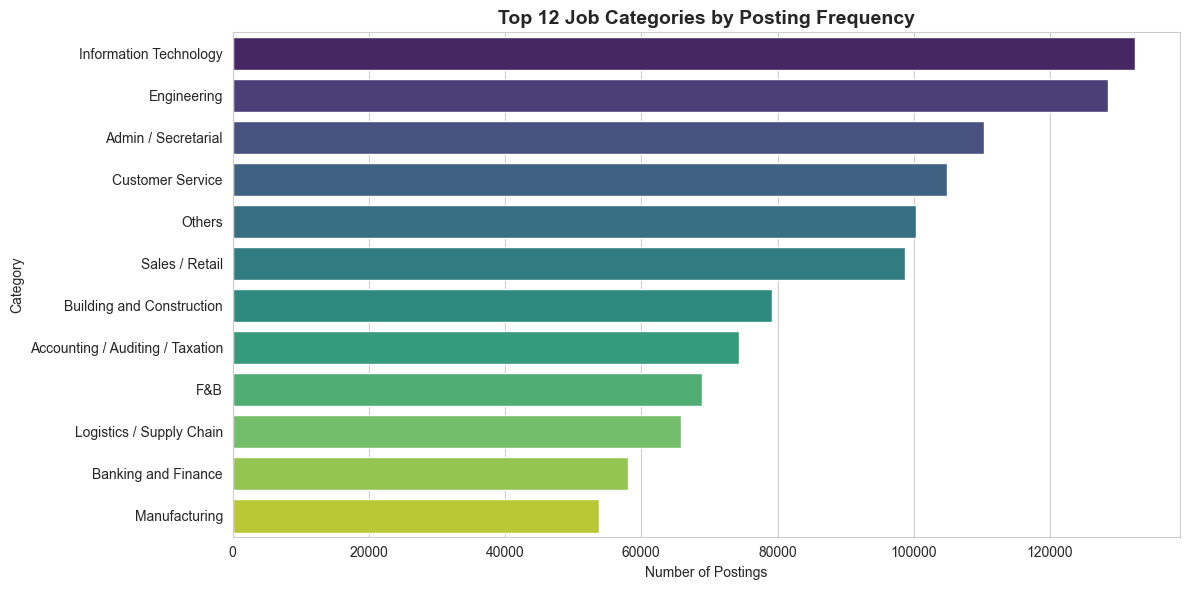

                                            categories employmentTypes  \
49   [{"id":2,"category":"Admin / Secretarial"},{"i...       Permanent   
52   [{"id":8,"category":"Customer Service"},{"id":...       Part Time   
69         [{"id":2,"category":"Admin / Secretarial"}]       Full Time   
84                [{"id":11,"category":"Engineering"}]       Permanent   
107    [{"id":33,"category":"Repair and Maintenance"}]       Full Time   

    metadata_expiryDate  metadata_isPostedOnBehalf metadata_jobPostId  \
49           2023-06-08                      False   MCF-2023-0182953   
52           2023-06-10                      False   MCF-2023-0274074   
69           2023-06-23                      False   MCF-2023-0120245   
84           2023-07-26                      False   MCF-2023-0274184   
107          2023-06-08                      False   MCF-2023-0183287   

    metadata_newPostingDate metadata_originalPostingDate  \
49               2023-05-09                   2023-03-08

In [10]:
# Flatten and count all categories
all_categories = []
for cats in df_filtered['category_list']:
    all_categories.extend(cats)

category_counts = Counter(all_categories)
category_df = pd.DataFrame(category_counts.items(), columns=['Category', 'Count']).sort_values('Count', ascending=False)

print("Top 15 Job Categories by Demand:")
print(category_df.head(15))

# Visualize top categories
plt.figure(figsize=(12, 6))
sns.barplot(data=category_df.head(12), x='Count', y='Category', palette='viridis')
plt.title('Top 12 Job Categories by Posting Frequency', fontsize=14, fontweight='bold')
plt.xlabel('Number of Postings')
plt.tight_layout()
plt.show()

print(df_filtered.head())

In [16]:
from collections import Counter

# Create a clean combination key: sorted tuple of non-empty categories
def get_category_combo(row):
    cats = [row[f'category_{i+1}'] for i in range(5) if row[f'category_{i+1}'].strip() != '']
    return tuple(sorted(cats)) if cats else ('Uncategorized',)

df_filtered['category_combo'] = df_filtered.apply(get_category_combo, axis=1)

# Overall top combinations
combo_counts = df_filtered['category_combo'].value_counts()

print("Top 20 Category Combinations (including singles):")
combo_df = combo_counts.head(20).reset_index()
combo_df.columns = ['category_combo', 'Job_Postings']
combo_df['category_combo'] = combo_df['category_combo'].apply(lambda x: ' / '.join(x))
print(combo_df.to_string(index=False))

# Separate single vs multi-category
single_category = combo_counts[combo_counts.index.map(len) == 1]
multi_category = combo_counts[combo_counts.index.map(len) > 1]

print("\nTop 10 Single-Category Postings:")
single_df = single_category.head(10).reset_index()
single_df.columns = ['category_combo', 'Job_Postings']
single_df['category_combo'] = single_df['category_combo'].apply(lambda x: ' / '.join(x))
print(single_df.to_string(index=False))

print("\nTop 20 Multi-Category Combinations (true hybrids):")
multi_df = multi_category.head(20).reset_index()
multi_df.columns = ['category_combo', 'Job_Postings']
multi_df['category_combo'] = multi_df['category_combo'].apply(lambda x: ' & '.join(x))
print(multi_df.to_string(index=False))

# Quick stats
print(f"\nMulti-category jobs: {len(multi_category)} combinations, covering {multi_category.sum():,} postings "
      f"({multi_category.sum()/len(df_filtered)*100:.1f}% of total)")

Top 20 Category Combinations (including singles):
                         category_combo  Job_Postings
                 Information Technology         87338
                            Engineering         46495
                                    F&B         45215
       Accounting / Auditing / Taxation         42337
              Building and Construction         41755
                    Admin / Secretarial         37723
               Logistics / Supply Chain         29841
                         Sales / Retail         29177
                 Education and Training         27233
                    Banking and Finance         24894
                                 Others         22844
            Healthcare / Pharmaceutical         22068
                        Human Resources         18880
           Marketing / Public Relations         16655
                       Customer Service         16147
                          Manufacturing         11142
            Sciences / Laborator